In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report

In [2]:
data_train=pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')

In [3]:
print('Shape of train dataset is {}'.format(data_train.shape))
print('Shape of test dataset is {}'.format(data_test.shape))

Shape of train dataset is (9557, 143)
Shape of test dataset is (23856, 142)


### Identify the output variable.

In [4]:
target_col = ""
for i in data_train.columns:
    if i not in data_test.columns:
        target_col = i
        print("Our output variable is {}".format(i))
        break

Our output variable is Target


### Understand the type of data.

In [5]:
data_train.dtypes.value_counts()

int64      130
float64      8
object       5
dtype: int64

In [6]:
data_train.select_dtypes(include='object')

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no
...,...,...,...,...,...
9552,ID_d45ae367d,d6c086aa3,.25,9,no
9553,ID_c94744e07,d6c086aa3,.25,9,no
9554,ID_85fc658f8,d6c086aa3,.25,9,no
9555,ID_ced540c61,d6c086aa3,.25,9,no


### Check if there are any biases in your dataset.

In [7]:
(data_train[target_col].value_counts() / data_train.shape[0]) * 100

4    62.739353
2    16.710265
3    12.650413
1     7.899969
Name: Target, dtype: float64

Above data shows that about 62% of people in training dataset fall under category `4` level of poverty

[Text(0.5, 1.0, "Distribution of 'v18q1'")]

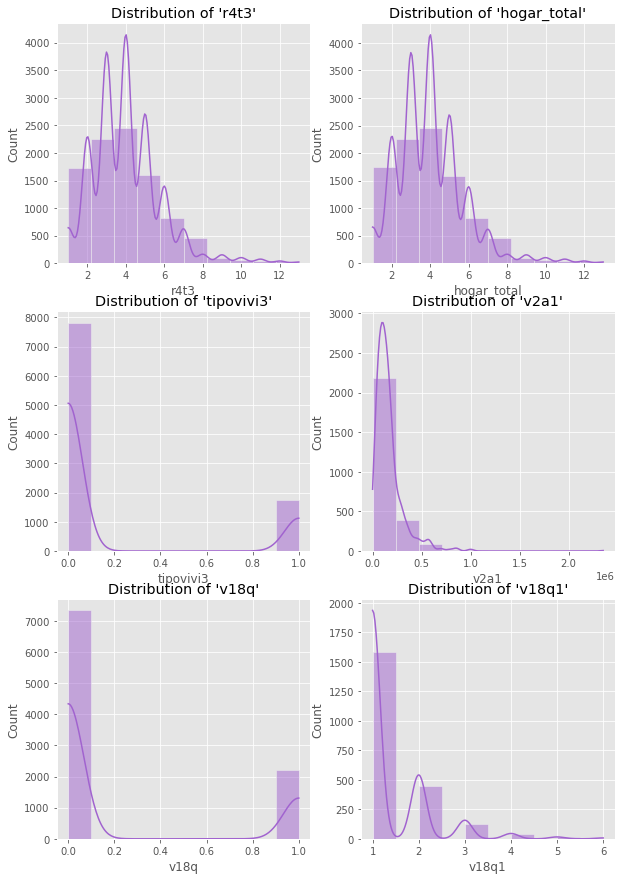

In [8]:
fig, axes = plt.subplots(3,2,figsize=(10,15))

sns.histplot(ax=axes[0,0], x=data_train['r4t3'],
            bins= 10, kde = True, cbar = True,
            color = '#A163CF').set(title = "Distribution of 'r4t3'")

sns.histplot(ax=axes[0,1], x=data_train['hogar_total'],
            bins = 10, kde = True, cbar = True,
            color = '#A163CF').set(title = "Distribution of 'hogar_total'")

sns.histplot(ax=axes[1,0], x=data_train['tipovivi3'],
            bins = 10, kde = True, cbar = True,
            color = '#A163CF').set(title= "Distribution of 'tipovivi3'")

sns.histplot(ax=axes[1,1], x=data_train['v2a1'],
            bins=10, kde=True,cbar = True,
            color = '#A163CF').set(title="Distribution of 'v2a1'")

sns.histplot(ax=axes[2,0],x=data_train['v18q'],
            bins=10, kde = True, cbar = True,
            color = '#A163CF').set(title="Distribution of 'v18q'")

sns.histplot(ax=axes[2,1],x=data_train['v18q1'],
            bins=10, kde = True, cbar = True,
            color = '#A163CF').set(title="Distribution of 'v18q1'")

Therefore,variables ('r4t3','hogar_total') have relationship between them. For good result we can use any one of them.
Therefore,variables ('tipovivi3','v2a1') have relationship between them. For good result we can use any one of them.
Therefore,variables ('v18q','v18q1') have relationship between them. For good result we can use any one of them.
So,*Therefore, there is bias in our dataset.*

### Check whether all members of the house have the same poverty level.

In [9]:
# Group By data wrt to family ID
family_group = data_train.groupby('idhogar')

In [10]:
# Get the count unique count of Target variable
unique_poverty_status = family_group[target_col].nunique()
# unique_poverty_status[unique_poverty_status > 1].index
any(unique_poverty_status > 1)

True

In [11]:
sum(unique_poverty_status > 1), unique_poverty_status.shape[0]

(85, 2988)

Above data shows that there are some families where members are of different poverty category within same family.
Out of 2988 Families in dataset about 85 families have shown this behaviour

### Check if there is a house without a family head.

In [12]:
num_head_in_family = family_group.parentesco1.sum()
any(num_head_in_family == 0)

True

In [13]:
num_head_in_family[num_head_in_family == 0].shape[0], num_head_in_family.shape[0]

(15, 2988)

Above data shows that out 2988 families about 15 families don't have family head in training dataset

### Set the poverty level of the members and the head of the house same in a family.

In [14]:
def set_poverty_level_as_head(group):
    head_poverty_level = group[group.parentesco1 == 1].Target
    if not head_poverty_level.empty:
        group.Target = head_poverty_level.values[0]
    return group

In [15]:
# update training data 
data_train = family_group.apply(set_poverty_level_as_head)

### Count how many null values are existing in columns.

In [16]:
null_col_count = data_train.isnull().sum()
null_col_count[null_col_count != 0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

##### Checking null of v2a1

In [17]:
data = data_train[data_train['v2a1'].isnull()].head()

columns=['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']
data[columns]

,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5
2,1,0,0,0,0
13,1,0,0,0,0
14,1,0,0,0,0
26,1,0,0,0,0
32,1,0,0,0,0


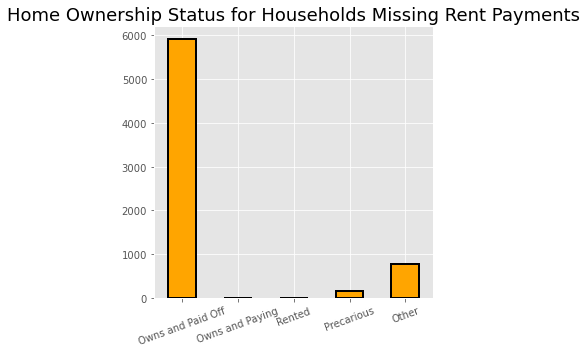

In [18]:
# Variables indicating home ownership
own_variables = [x for x in data_train if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent payments
data_train.loc[data_train['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (5, 5),
                                                                        color = 'orange',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 20)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

In [19]:
data_train['v2a1'].fillna(0,inplace=True)

Looking at the above data it makes sense that when the house is fully paid, there will be no monthly rent payment.
So, added 0 for all the null values.

##### Checking null values of v18q1 

In [20]:
data_train['v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [21]:
data_train['v18q1'].isna().sum()

7342

In [22]:
data_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [23]:
data_train['v18q1'].fillna(0,inplace=True)

Looking at the above data it makes sense that when owns a tablet column is 0, 
there will be no number of tablets household owns. So, added 0 for all the null values.

##### Checking for null values rez_esc

Lets look at rez_esc : Years behind in school  

In [24]:
data_train[data_train['rez_esc'].notnull()]['age'].describe()

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

From the above , we see that when min age is 7 and max age is 17 for Years, then the 'behind in school' column has a value.


In [25]:
data_train.loc[data_train['rez_esc'].isnull()]['age'].describe()

count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64

In [26]:
data_train.loc[(data_train['rez_esc'].isnull() & ((data_train['age'] > 7) & (data_train['age'] < 17)))]['age'].describe()

count     1.0
mean     10.0
std       NaN
min      10.0
25%      10.0
50%      10.0
75%      10.0
max      10.0
Name: age, dtype: float64

There is one value that has Null for the 'behind in school' column with age between 7 and 17 

In [27]:
data_train[(data_train['age'] ==10) & data_train['rez_esc'].isnull()].head()
data_train[(data_train['Id'] =='ID_f012e4242')].head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
2514,ID_f012e4242,160000.0,0,6,0,1,1,1,1.0,0,...,0,100,9,121,1,2.25,0.25,182.25,100,4


There is only one member in household for the member with age 10 and who is 'behind in school'. This explains why the member is 
behind in school.

In [28]:
for data in [data_train, data_test]:
    data['rez_esc'].fillna(value=0, inplace=True)
data_train[['rez_esc']].isnull().sum()

rez_esc    0
dtype: int64

##### Checking for null values meaneduc

In [29]:
data = data_train[data_train['meaneduc'].isnull()].head()

columns=['edjefe','edjefa','instlevel1','instlevel2']
data[columns][data[columns]['instlevel1']>0].describe()

,instlevel1,instlevel2
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [30]:
for data in [data_train, data_test]:
    data['meaneduc'].fillna(value=0, inplace=True)
data_train[['meaneduc']].isnull().sum()

meaneduc    0
dtype: int64

#####  Checking for null values SQBmeaned

In [31]:
for data in [data_train, data_test]:
    data['SQBmeaned'].fillna(value=0, inplace=True)
data_train[['SQBmeaned']].isnull().sum()

SQBmeaned    0
dtype: int64

We find that SQBmeaned is null when no level of education is 0

### Remove null value rows of the target variable.

In [32]:
data_train[target_col].isnull().sum()

0

No Null values found in train data set for Target column

### Predict the accuracy using random forest classifier. (Try other models too)

##### Data Processing

#### Categorise alpha numeric column

###### Dependency

In [33]:
# Dependency: # of members less than 19 or more than 64 / # of memebers b/w 19 and 64 
data_train['dependency'].value_counts()

yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
.40000001      84
1.3333334      84
2.5            77
5              24
1.25           18
3.5            18
.80000001      18
2.25           13
.71428573      12
1.75           11
1.2            11
.83333331      11
.22222222      11
.2857143        9
1.6666666       8
.60000002       8
6               7
.16666667       7
Name: dependency, dtype: int64

Since it is not clear if how much does a yes quantify to proceeding with assumption of 1 for `yes` and 0 for `no`

In [34]:
def map(i):
    
    if i=='yes':
        return(float(1))
    elif i=='no':
        return(float(0))
    else:
        return(float(i))

In [35]:
data_train['dependency']=data_train['dependency'].apply(map)

In [36]:
data_train.dependency.dtypes

dtype('float64')

In [37]:
data_train['dependency'].isnull().sum()

0

###### edjefe & edjefa

`edjefe` and `edjefa` features are not clear and wasn't able to find proper definiton so dropping them.

In [38]:
data_train = data_train.drop(columns = ['edjefe', 'edjefa'])

###### train & test split

In [39]:
X = data_train.drop(columns=[target_col])

In [40]:
y = data_train[[target_col]]

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    train_size=0.8)

In [42]:
X_train.shape

(7645, 140)

In [43]:
X_test.shape

(1912, 140)

#### EDA

###### Output variable distribution

In [44]:
target_counts=(y_train[target_col].value_counts() / y_train.shape[0]) * 100
target_counts

4    63.047744
2    16.429039
3    12.609549
1     7.913669
Name: Target, dtype: float64

<AxesSubplot:title={'center':'Target vs Total_Count'}>

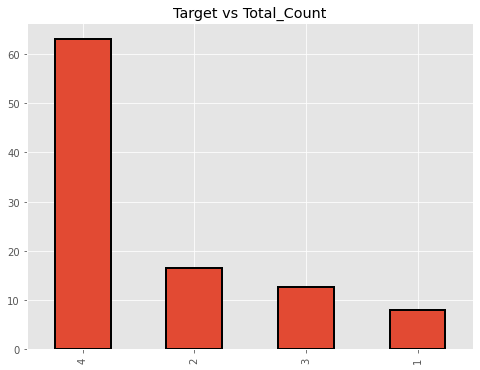

In [45]:
target_counts.plot.bar(figsize = (8, 6),linewidth = 2,edgecolor = 'k',title="Target vs Total_Count")

###### Output variable trends with raw data available 

In [46]:
X_train['output_label'] = y_train.values

<AxesSubplot:xlabel='output_label'>

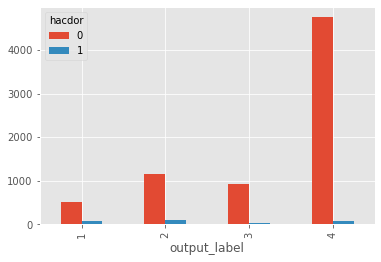

In [47]:
X_train.groupby(['output_label', 'hacdor']).Id.count().unstack().plot(kind='bar')

Hacdor doesn't seems to provide valuable insight about a person being in particular poverty category or not except for the fact that already biased data showing that if they don't have overcrouded bedroom they are likely to be in category `4`, will have to revisit about viability of this feature later

<AxesSubplot:xlabel='rooms'>

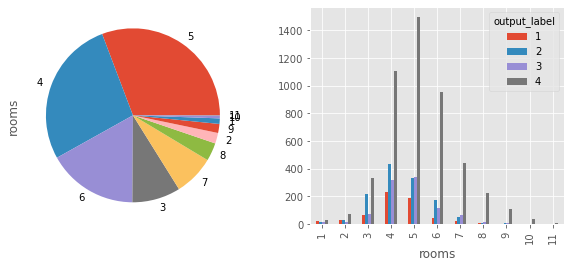

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
room_distribution = X_train['rooms'].value_counts()
room_count_x_output_label = X_train.groupby(['rooms', 'output_label']).Id.count().unstack()
room_distribution.plot(ax=axes[0], kind='pie')
room_count_x_output_label.plot(ax=axes[1], kind='bar')

The graph above shows that most of the house holds have 5 rooms or 4 rooms per house of family covering more than 50% of data available in training set, however couldn't find a reliable pattern with output label

In [49]:
X_train.groupby(['output_label', 'v18q']).Id.count().unstack()

v18q,0,1
output_label,,
1,561,44
2,1162,94
3,851,113
4,3324,1496


Above matrix shows that it is more likely that if a person owns a tablet, he is more likely to be category 4 compared to other categories but this could still also be due to the bias in data from category 4 

we can make gender column from `male` and `female` column

In [50]:
X_train[['male', 'female']].head(5)

,male,female
9025,0,1
742,0,1
180,1,0
1115,0,1
9090,1,0


In [51]:
X_train['gender'] = np.where(X_train['female'], 1, 0)

In [52]:
X_train.groupby(['output_label', 'gender']).Id.count().unstack()

gender,0,1
output_label,,
1,264,341
2,600,656
3,454,510
4,2406,2414


The distribution of poverty marking seems to qually distributed across genders

Similarly we can reduce Zone column into single column

In [53]:
X_train['zone'] = np.where(X_train['area1'], 1, 0)

<AxesSubplot:xlabel='output_label'>

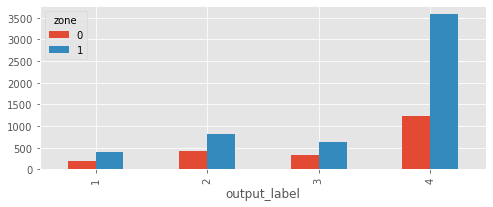

In [54]:

X_train.groupby(['output_label', 'zone']).Id.count().unstack().plot(kind='bar', figsize=(8, 3))

Above graph shows a skewness of higher chance of people being in urban zone compared to rural and fall under category 4 however even for rural category 4 seems to be the prominent one.

Combining regions to get better perspective of distribution across region for poverty

In [55]:
X_train[['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']].head(3)

,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6
9025,0,0,0,0,0,1
742,1,0,0,0,0,0
180,1,0,0,0,0,0


In [56]:
X_train['region'] = np.where(
        X_train['lugar1'] == 1, "Central",
        np.where(
            X_train['lugar2'] == 1, "Chorotega",
            np.where(
                X_train['lugar3'] == 1, "PacÃƒÂfico central",
                np.where(
                    X_train['lugar4'] == 1, "Brunca",
                    np.where(
                        X_train['lugar5'] == 1, "Huetar AtlÃƒÂ¡ntica",
                        "Huetar Norte"
                    )
                )
            )
        )
)

<AxesSubplot:xlabel='output_label'>

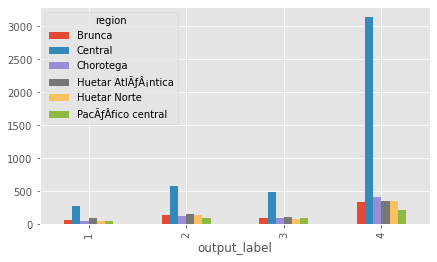

In [57]:
X_train.groupby(['output_label', 'region']).Id.count().unstack().plot(kind='bar', figsize=(7, 4))

Above graph shows that majority of population is from central part and that too has a prominent category 4 population, this could also be due to inherit bias in data for category 4

In [58]:
region_map = {
    "Central": 0, "Chorotega": 1, "PacÃƒÂfico central": 2, "Brunca": 3, "Huetar AtlÃƒÂ¡ntica": 4, "Huetar Norte": 5
}

In [59]:
X_train['region'] = X_train['region'].map(region_map)

<AxesSubplot:ylabel='Frequency'>

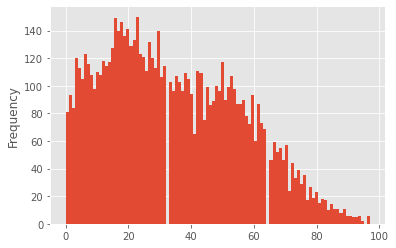

In [60]:
X_train['age'].plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

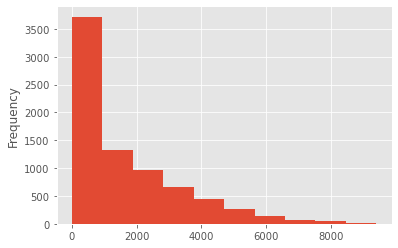

In [61]:
X_train['agesq'].plot(kind='hist')

Age seems to be a right skewed distribution with majority of people being in age band of 15-30 years roughly.

<AxesSubplot:xlabel='qmobilephone'>

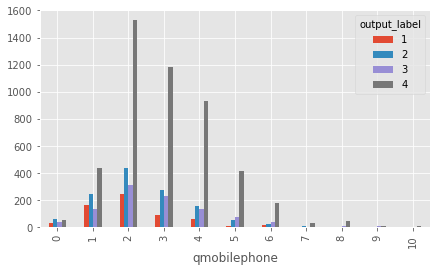

In [62]:
X_train.groupby(['qmobilephone','output_label']).Id.count().unstack().plot(kind='bar', figsize=(7, 4))

In [63]:
X_train['has_mobile_or_phone'] = np.where(X_train['qmobilephone'] == 0, 0, 1)

In [64]:
X_train.groupby(['has_mobile_or_phone', 'output_label']).Id.count().unstack()

output_label,1,2,3,4
has_mobile_or_phone,,,,
0,31,60,39,54
1,574,1196,925,4766


Couldn't find a valuable insight from a person being in poverty and having of mobile or phone 

In [65]:
X_train[['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']] 

,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5
9025,1,0,0,0,0
742,0,1,0,0,0
180,1,0,0,0,0
1115,0,0,1,0,0
9090,0,1,0,0,0
...,...,...,...,...,...
5734,0,1,0,0,0
5191,1,0,0,0,0
5390,0,0,0,0,1
860,0,0,1,0,0


In [66]:
X_train['house_status'] = np.where(
        X_train['tipovivi1'] == 1, "Owns house",
        np.where(
            X_train['tipovivi2'] == 1, "Owns, paying installment",
            np.where(
                X_train['tipovivi3'] == 1, "Rented",
                np.where(
                    X_train['tipovivi4'] == 1, "Precarious",
                    "other(assigned, borrowed)"    
                    )
                )
            )
        )

<AxesSubplot:xlabel='output_label'>

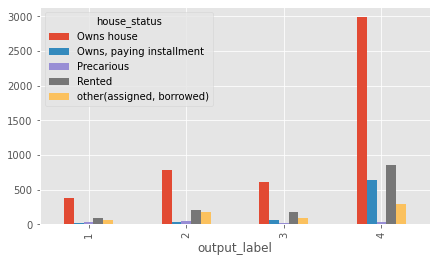

In [67]:
X_train.groupby(['output_label', 'house_status']).Id.count().unstack().plot(kind='bar', figsize=(7, 4))

House status shows an intresting insight that you are less likely to be in category 4 of target value if your house status is Precarious

In [68]:
map_house_status = {
    "Owns house": 0, "Owns, paying installment": 1, "Rented": 2, "Precarious": 3, "other(assigned, borrowed)": 4
}

In [69]:
X_train['house_status'] = X_train['house_status'].map(map_house_status)

In [70]:
X_train = X_train.drop(columns = ['Id','idhogar','output_label'])

#### Feature Engineering

In [71]:
# Gender
X_test['gender'] = np.where(X_test['female'], 1, 0)
# Zone
X_test['zone'] = np.where(X_test['area1'], 1, 0)
#Has mobile or not
X_test['has_mobile_or_phone'] = np.where(X_test['qmobilephone'] == 0, 0, 1)
# Region
X_test['region'] = np.where(
        X_test['lugar1'] == 1, "Central",
        np.where(
            X_test['lugar2'] == 1, "Chorotega",
            np.where(
                X_test['lugar3'] == 1, "PacÃƒÂfico central",
                np.where(
                    X_test['lugar4'] == 1, "Brunca",
                    np.where(
                        X_test['lugar5'] == 1, "Huetar AtlÃƒÂ¡ntica",
                        "Huetar Norte"
                    )
                )
            )
       )
  )

# House Status
X_test['house_status'] = np.where(
        X_test['tipovivi1'] == 1, "Owns house",
        np.where(
            X_test['tipovivi2'] == 1, "Owns, paying installment",
            np.where(
                X_test['tipovivi3'] == 1, "Rented",
                np.where(
                    X_test['tipovivi4'] == 1, "Precarious",
                    "other(assigned, borrowed)"    
                    )
                )
            )
        )

In [72]:
X_test['region'] = X_test['region'].map(region_map)

In [73]:
X_test['house_status'] = X_test['house_status'].map(map_house_status)

In [74]:
X_test = X_test.drop(columns = ['Id','idhogar'])

## Models

#### RandomForest

In [75]:
model = RandomForestClassifier()

In [76]:
model.fit(X_train,y_train)

/var/folders/3c/lwghlsts08s19tyjdbv2ssd00000gn/T/ipykernel_93407/2721349307.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RandomForestClassifier()

In [77]:
y_predict = model.predict(X_test)

/Users/saishruthicherukuri/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [78]:
print(accuracy_score(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))

0.9288702928870293
[[ 144    3    0   22]
 [   5  258    0   39]
 [   2    4  195   56]
 [   0    4    1 1179]]
              precision    recall  f1-score   support

           1       0.95      0.85      0.90       169
           2       0.96      0.85      0.90       302
           3       0.99      0.76      0.86       257
           4       0.91      1.00      0.95      1184

    accuracy                           0.93      1912
   macro avg       0.95      0.87      0.90      1912
weighted avg       0.93      0.93      0.93      1912



###### Random Forest with K Folds

In [79]:
from sklearn.model_selection import KFold,cross_val_score

In [80]:
x_features=data_train.iloc[:,0:-1]
y_features=data_train.iloc[:,-1]
print(x_features.shape)
print(y_features.shape)

(9557, 140)
(9557,)


In [81]:
x_features = x_features.drop(columns = ['Id','idhogar'])

###### Checking the score using default 10 trees

In [82]:
seed=7
kfold=KFold(n_splits=5,random_state=seed,shuffle=True)
model=RandomForestClassifier(random_state=10,n_jobs = -1)
print(cross_val_score(model,x_features,y_features,cv=kfold,scoring='accuracy',error_score='raise'))
results=cross_val_score(model,x_features,y_features,cv=kfold,scoring='accuracy',error_score='raise')
print(results.mean()*100)

[0.93410042 0.94142259 0.92935636 0.93040293 0.93092622]
93.32417035047041


###### Checking the score using 100 trees

In [83]:
num_trees= 100

model=RandomForestClassifier(n_estimators=100, random_state=10,n_jobs = -1)
print(cross_val_score(model,x_features,y_features,cv=kfold,scoring='accuracy'))
results=cross_val_score(model,x_features,y_features,cv=kfold,scoring='accuracy')
print(results.mean()*100)

[0.93410042 0.94142259 0.92935636 0.93040293 0.93092622]
93.32417035047041


In [84]:
model.fit(x_features,y_features)
labels = list(x_features)
feature_importances = pd.DataFrame({'feature': labels, 'importance': model.feature_importances_})
feature_importances=feature_importances[feature_importances.importance>0.015]
feature_importances.head()

,feature,importance
0,v2a1,0.015878
2,rooms,0.020800
9,r4h2,0.017319
10,r4h3,0.016323
13,r4m3,0.015872


Text(0.5, 0, 'Importance')

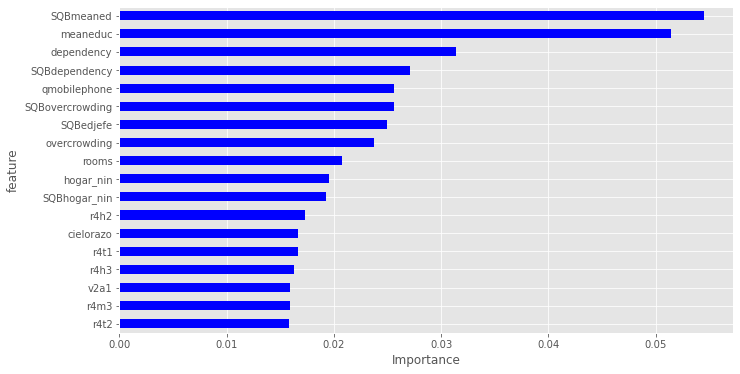

In [85]:
feature_importances.sort_values(by=['importance'], ascending=True, inplace=True)
feature_importances['positive'] = feature_importances['importance'] > 0
feature_importances.set_index('feature',inplace=True)
feature_importances.head()

feature_importances.importance.plot(kind='barh', figsize=(11, 6),color = feature_importances.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

In [86]:
feature_importances

,importance,positive
feature,,
r4t2,0.015845,True
r4m3,0.015872,True
v2a1,0.015878,True
r4h3,0.016323,True
r4t1,0.016652,True
cielorazo,0.016670,True
r4h2,0.017319,True
SQBhogar_nin,0.019292,True
hogar_nin,0.019557,True


In [87]:
for i in feature_importances:
    if i not in x_features:
        print(i)

importance
positive


In [88]:
X_data_Top_features= x_features[['r4t2','r4m3','v2a1','r4h3','r4t1','cielorazo','r4h2','r4t1','cielorazo','r4h2',
                               'SQBhogar_nin','hogar_nin','rooms','overcrowding','SQBedjefe','SQBovercrowding',
                                'qmobilephone','SQBdependency','dependency','meaneduc','SQBmeaned']]

In [89]:
X_train,X_test,Y_train,Y_test=train_test_split(X_data_Top_features,
                                               y_features,
                                               test_size=0.2,
                                               stratify=y_features,random_state=0)

In [90]:
X_data_Top_features.isnull().sum()

r4t2               0
r4m3               0
v2a1               0
r4h3               0
r4t1               0
cielorazo          0
r4h2               0
r4t1               0
cielorazo          0
r4h2               0
SQBhogar_nin       0
hogar_nin          0
rooms              0
overcrowding       0
SQBedjefe          0
SQBovercrowding    0
qmobilephone       0
SQBdependency      0
dependency         0
meaneduc           0
SQBmeaned          0
dtype: int64

In [91]:
model = RandomForestClassifier()
model_final=model.fit(X_train,Y_train)
Y_pred=model_final.predict(X_test)

In [92]:
print(accuracy_score(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))
print(f1_score(Y_test,Y_pred,average='weighted'))

0.9633891213389121
[[ 144    0    0   11]
 [   6  292    3   11]
 [   1    3  228   12]
 [   2    7   14 1178]]
              precision    recall  f1-score   support

           1       0.94      0.93      0.94       155
           2       0.97      0.94      0.95       312
           3       0.93      0.93      0.93       244
           4       0.97      0.98      0.98      1201

    accuracy                           0.96      1912
   macro avg       0.95      0.95      0.95      1912
weighted avg       0.96      0.96      0.96      1912

0.9633129858012178


## Test Data Cleaning and Prediction

In [93]:
# lets drop required variables.
data_test.drop(['Id','idhogar','edjefe','edjefa'],axis=1,inplace=True)
data_test['dependency']=data_test['dependency'].apply(map)

In [94]:
data_test['v2a1'].fillna(0,inplace=True)
data_test['v18q1'].fillna(0,inplace=True)
data_test['SQBmeaned'].fillna(0,inplace=True)
data_test['meaneduc'].fillna(0,inplace=True)

In [95]:
data_test.isna().sum().value_counts()

0    138
dtype: int64

In [96]:
data_test=data_test[['r4t2','r4m3','v2a1','r4h3','r4t1','cielorazo','r4h2','r4t1','cielorazo','r4h2',
                               'SQBhogar_nin','hogar_nin','rooms','overcrowding','SQBedjefe','SQBovercrowding',
                                'qmobilephone','SQBdependency','dependency','meaneduc','SQBmeaned']]

In [97]:
test_prediction=model_final.predict(data_test)

In [98]:
test_prediction

array([4, 4, 4, ..., 2, 2, 2])

### *Using RandomForest Classifier we can predict test data with accuracy of 96%.*